In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
#Regression Packages
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict
import statsmodels.formula.api as smf
#from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import neighbors
from sklearn import ensemble
#from sklearn.svm import SVR


In [5]:
class createSet(object): # Make this subclass pd dataframe? #https://stackoverflow.com/questions/22155951/how-to-subclass-pandas-dataframe
    '''This creates pandas dataframe of a specified size with generated features of
    various distributions and a dependent variable of a specified skewness. 
    
    This class also has a few methods for creating additional, completely random features with 
    a function call. These can be of specified distribution but are truly random and are likely
    to have correlations close to zero with the target variable.
    
    The outlier method removes rows at random and replaces them with outliers: use "all" to get
    extreme values in every column, or specify 'columns=[]' to get outliers in only some features.
    '''
    
    def __init__(self,size=10000, targetskew=0, corr=0.5, multicol=0.0):
        self.size = size
        
        #create a baseline dataset with the correlations we want. This creates a series 
        #with mean zero and std=1 and the correlations specified by the covariance matrix (cov=)
        mvnorm = stats.multivariate_normal(mean=[0, 0, 0, 0], cov=[[1., corr, corr, corr], 
                                                                  [corr, 1., multicol, multicol],
                                                                  [corr, multicol, 1., multicol],
                                                                  [corr, multicol, multicol, 1.]])
        raw = mvnorm.rvs(self.size)
        #create the target variable with the specified targetskew
        targetMean = 3000 #based on my own average of ~50 hours/month
        targetStd = 1000 #guess
        
        #Some of the features will be calculated using the target variable to artificially create some
        # correlation. However, I don't want them to automatically inherit the skewness of the target
        # variable, so instead of basing the independing variables directly on the target, I will 
        # create a normal distribution on the same scale that is sorted to match the order of the 
        # target variable. That enables creating correlated features without inheriting skew.
        if targetskew:
            self.standardNormalTarget =  raw[:,0]
            intendedSortOrder = stats.rankdata(self.standardNormalTarget, method='ordinal')
            sortedSkew = np.sort(stats.skewnorm.rvs(a=targetskew, loc=targetMean,scale=targetStd, size=self.size))
            self.minSpent = [sortedSkew[i-1] for i in intendedSortOrder]
            df = pd.DataFrame(self.minSpent, columns=['minSpent'])
        else:
            self.standardNormalTarget =  raw[:,0]
            intendedSortOrder = stats.rankdata(self.standardNormalTarget, method='ordinal')
            self.minSpent = self.standardNormalTarget*targetStd + targetMean
            df = pd.DataFrame(self.minSpent, columns=['minSpent'])
        

        
        
        #This adds a normally distributed feature with the correlations specified by the 2nd column of (cov=)
        #The std (3K) and mean (12K) are arbitrarily chosen to make the data intuitive (few/no negatives)
        df['screenActions'] = raw[:,1]*3000
        df['screenActions'] = df.screenActions - min(0,df.screenActions.min())
        df['screenActions'].astype('int') 

        #This adds a left-tailed skewed distributed feature with the correlations specified by the 3rd column of (cov=)
        #mean based on 2 pics per day for 30 days
        picSkew = np.sort(stats.skewnorm.rvs(a=-10, loc=60,scale=15, size=self.size))
        picSortOrder = stats.rankdata(raw[:,2], method='ordinal')
        df['picsTaken'] = [picSkew[i-1] for i in picSortOrder]
        df['picsTaken'] = df['picsTaken'].astype('int') 

        #This adds a right-tailed skewed distribution for owner's age        
        ageSkew = np.sort(stats.skewnorm.rvs(a=5, loc=25,scale=15, size=self.size))
        ageSortOrder = stats.rankdata(raw[:,3], method='ordinal')
        df['ownerAge'] = [ageSkew[i-1] for i in ageSortOrder]


        
        #This adds a poisson distribution that's typically around .17 correlation
        df['timesDropped'] = [np.random.poisson(lam=2) if x > 0 else 
                              np.random.poisson(lam=.5) for x in self.standardNormalTarget]


        #This adds a bernoulli distribution for whether the phone is rooted, typically around .06 correlation
        df['rooted'] = [np.random.binomial(1, .05) if x > 0 else
                        np.random.binomial(1, .005) for x in self.standardNormalTarget]

        #This adds a categorical variable that slightly corresponds to the target
        def osChoice(self, p):
            return np.random.choice(a=['iOS', 'Android', 'other'], p=p)
        df['os'] = [osChoice(self,[.415,.575,.01]) if x > targetMean else 
                               osChoice(self,[.335,.635,.03]) for x in self.standardNormalTarget]
               
        self.df = df
        
    def addContFeatures(self, feats={'normal':1}):
        for shape, cnt in feats.items():
            if shape == 'normal':
                for j in range(cnt):
                    Y = np.random.normal(loc=targetMean,scale=targetStd, size=self.size)
                    self.df['normalFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'uniform':
                for j in range(cnt):
                    Y = np.random.uniform(size=self.size)*(targetMean*2)
                    self.df['uniformFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'poisson':
                for j in range(cnt):
                    Y = np.random.poisson(lam=1.0,size=self.size)
                    self.df['poissonFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'gamma':
                for j in range(cnt):
                    Y = np.random.gamma(shape=2.0,scale=2,size=self.size)
                    self.df['gammaFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
                    
                
            else:
                print('NOTE: received invalid distribution type. Try \"normal\", \"uniform\", or ')
    
    def addCatFeatures(self, feats={'sex':['male', 'female']}):
        for name, values in feats.items():
            odds = np.random.randint(low=0, high=len(values),size=self.size)
            self.df[name] = [values[x] for x in odds]
            del odds
            
    def addOutliers(self, cnt=5):
        #code this
        self.df = df
        
        
        
            
        

In [6]:
#this cell doesn't need to run; It checks 100 iterations of the class createSet() to see how the features
# tend to correlate with the target variable (given that they are generated dynamically)
#It's only useful when I update how a feature is calculated

import time
start = time.time()
screencorrs = []
picscorrs = []
dropscorrs = []
agecorrs = []
rootcorrs = []
for i in range(100):
    u = createSet(size=1000)
    cor = u.df.corr()
    screencorrs.append(cor.loc['minSpent','screenActions'])
    picscorrs.append(cor.loc['minSpent','picsTaken'])
    dropscorrs.append(cor.loc['minSpent','timesDropped'])
    agecorrs.append(cor.loc['minSpent','ownerAge'])
    rootcorrs.append(cor.loc['minSpent','rooted'])
print('Correlations: \n')
print('screenActions (Normal Variable)\n',np.mean(screencorrs),'\n', np.std(screencorrs), '\n')
print('picsTaken (Skewed Variable) \n',np.mean(picscorrs),'\n', np.std(picscorrs), '\n')
print('timesDropped (Poisson Variable) \n',np.mean(dropscorrs),'\n', np.std(dropscorrs), '\n')
print('ownerAge (Skewed Variable) \n',np.mean(agecorrs),'\n', np.std(agecorrs), '\n')
print('rooted (Bernoulli Variable)\n',np.mean(rootcorrs),'\n', np.std(rootcorrs), '\n')
print('done in ', time.time() - start, 'seconds')
u.df.corr()

Correlations: 

screenActions (Normal Variable)
 0.5031867269743866 
 0.023426477770399197 

picsTaken (Skewed Variable) 
 0.4836155444374824 
 0.023208658995749355 

timesDropped (Poisson Variable) 
 0.44578051970131993 
 0.02212264949813614 

ownerAge (Skewed Variable) 
 0.4889145116247693 
 0.024381933294795273 

rooted (Bernoulli Variable)
 0.10713166515713174 
 0.02775326420386156 

done in  4.730609893798828 seconds


,minSpent,screenActions,picsTaken,ownerAge,timesDropped,rooted
minSpent,1.000000,0.513319,0.486888,0.477234,0.431719,0.113510
screenActions,0.513319,1.000000,0.006136,0.030654,0.211033,0.060020
picsTaken,0.486888,0.006136,1.000000,-0.030587,0.186277,0.070539
ownerAge,0.477234,0.030654,-0.030587,1.000000,0.218370,0.042237
timesDropped,0.431719,0.211033,0.186277,0.218370,1.000000,0.056547
rooted,0.113510,0.060020,0.070539,0.042237,0.056547,1.000000


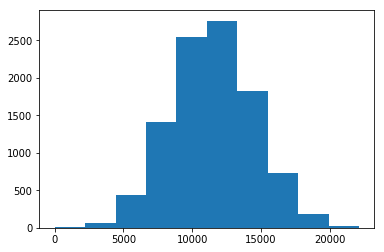

minSpent        -2039.09
screenActions          0
picsTaken              3
ownerAge         15.1872
timesDropped           0
rooted                 0
os               Android
dtype: object

minSpent         6908.72
screenActions    22115.5
picsTaken             63
ownerAge         82.4979
timesDropped           9
rooted                 1
os                 other
dtype: object

In [7]:
u = createSet(size=10000)
plt.hist(u.df.screenActions)
plt.show()
display(u.df.min())
display(u.df.max())

---------------------------------------------------------------------------

---------------------------------------------------------------------------

---------------------------------------------------------------------------

---------------------------------------------------------------------------

_________________

In [8]:
#Let's create one for vizualization

viz = createSet(targetskew=0)
print(viz.df.shape)
display(viz.df.head())
viz.df.corr()

(10000, 7)


,minSpent,screenActions,picsTaken,ownerAge,timesDropped,rooted,os
0,1255.216496,12844.481974,15,34.291653,0,0,Android
1,2171.387075,7511.495187,54,32.711267,0,0,Android
2,2341.399577,11340.499082,39,26.469405,0,0,Android
3,3144.938936,5858.932922,57,34.209267,3,0,Android
4,2549.083743,13690.555069,41,27.668864,0,0,Android


,minSpent,screenActions,picsTaken,ownerAge,timesDropped,rooted
minSpent,1.000000,0.481715,0.497879,0.486670,0.442196,0.114052
screenActions,0.481715,1.000000,0.008086,-0.014884,0.214759,0.051802
picsTaken,0.497879,0.008086,1.000000,0.015676,0.228543,0.046409
ownerAge,0.486670,-0.014884,0.015676,1.000000,0.208377,0.058654
timesDropped,0.442196,0.214759,0.228543,0.208377,1.000000,0.058224
rooted,0.114052,0.051802,0.046409,0.058654,0.058224,1.000000


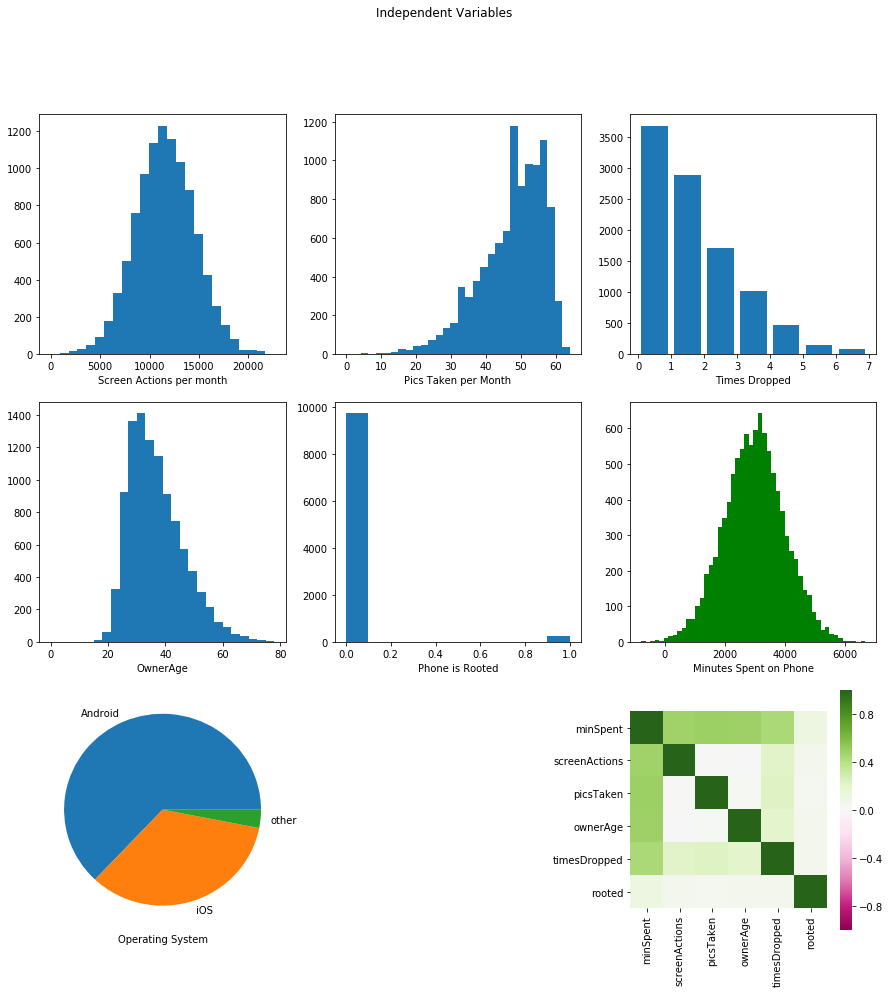

In [9]:
#Core feature Histograms

plt.figure(figsize=(15,15))
plt.suptitle('Independent Variables')
plt.subplot(331)
plt.hist(viz.df.screenActions, bins=25)
plt.xlabel('Screen Actions per month')
plt.subplot(332)
plt.hist(viz.df.picsTaken, bins=30)
plt.xlabel('Pics Taken per Month')
plt.subplot(333)
plt.hist(viz.df.timesDropped, bins=np.arange(0,max(viz.df.timesDropped),1), rwidth = .8)
plt.xlabel('Times Dropped')
plt.subplot(334)
plt.hist(viz.df.ownerAge, bins=np.arange(0,max(viz.df.ownerAge),3))
plt.xlabel('OwnerAge')
plt.subplot(335)
plt.hist(viz.df.rooted)#, bins=np.arange(0,40,3))
plt.xlabel('Phone is Rooted')
plt.subplot(336)
plt.hist(viz.df.minSpent, color='g', bins=50)#, bins=np.arange(0,40,3))
plt.xlabel('Minutes Spent on Phone')
plt.ylabel('')
plt.subplot(337)
viz.df['os'].value_counts().plot(kind='pie')
plt.ylabel('')
plt.xlabel('Operating System')
plt.subplot(339)
sns.heatmap(viz.df.corr(), vmin = -1,square=True, cmap="PiYG")
plt.show()

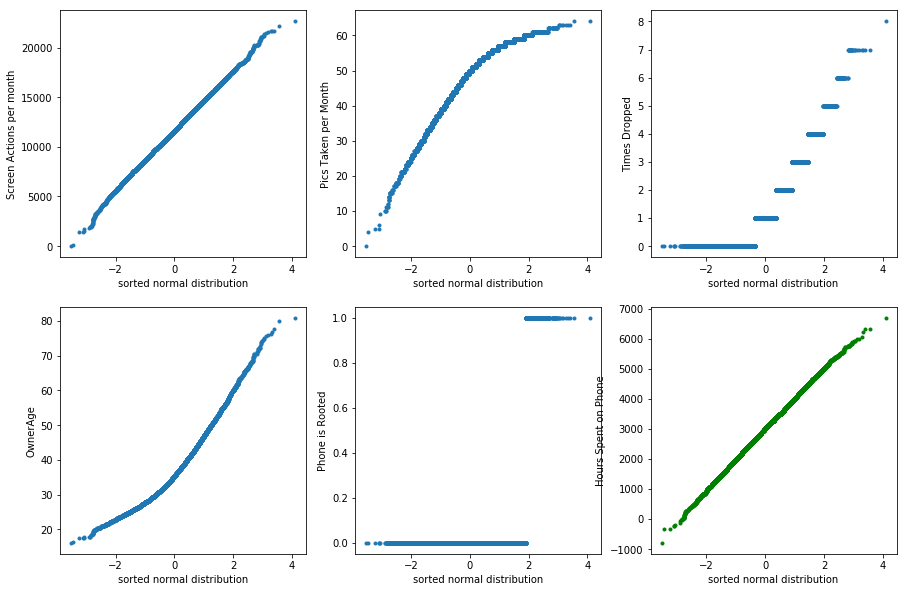

In [10]:
#Quartile Plot compared to random normal

norm = np.random.normal(0, 1, viz.size)
norm.sort()
norm1 = viz.df['screenActions'].sort_values()
uni2 =  viz.df['picsTaken'].sort_values()
pois3 =  viz.df['timesDropped'].sort_values()
gamma4 = viz.df['ownerAge'].sort_values()
bern = viz.df['rooted'].sort_values()
target = viz.df['minSpent'].sort_values()

plt.figure(figsize=(15,10))
plt.subplot(231)
plt.plot(norm, norm1, ".")
plt.xlabel('sorted normal distribution')
plt.ylabel('Screen Actions per month')
plt.subplot(232)
plt.plot(norm, uni2, ".")
plt.ylabel('Pics Taken per Month')
plt.xlabel('sorted normal distribution')
plt.subplot(233)
plt.plot(norm, pois3, ".")
plt.ylabel('Times Dropped')
plt.xlabel('sorted normal distribution')
plt.subplot(234)
plt.plot(norm, gamma4, ".")
plt.ylabel('OwnerAge')
plt.xlabel('sorted normal distribution')
plt.subplot(235)
plt.plot(norm, bern, ".")
plt.ylabel('Phone is Rooted')
plt.xlabel('sorted normal distribution')
plt.subplot(236)
plt.plot(norm, target, "g.")
plt.ylabel('Hours Spent on Phone')
plt.xlabel('sorted normal distribution')
plt.show()

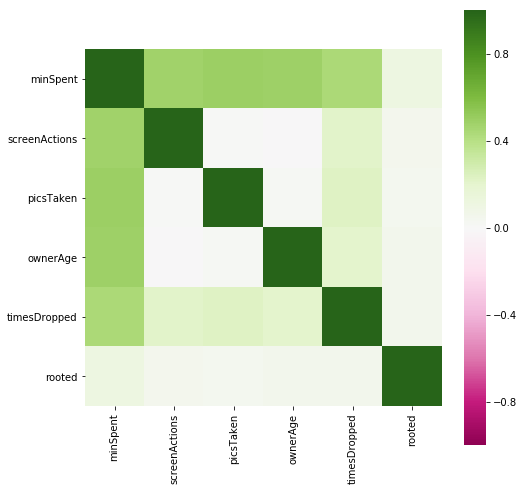

In [11]:
plt.figure(figsize=[8,8])
sns.heatmap(viz.df.corr(), vmin = -1,square=True, cmap="PiYG")
plt.show()

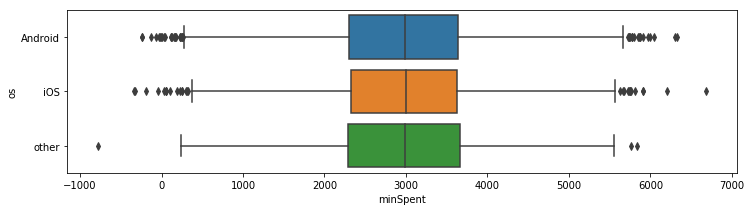

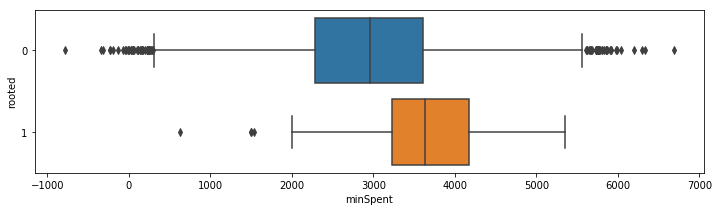

In [12]:
plt.figure(figsize=[12,3])
sns.boxplot(x='minSpent', y='os', data=viz.df, orient='h')
plt.show()
plt.figure(figsize=[12,3])
sns.boxplot(x='minSpent', y='rooted', data=viz.df, orient='h')
plt.show()

# Baseline: Linear Regression of a normally distributed dependent variable using 1 normally distributed feature

In [13]:
normal = createSet(targetskew=0, size=10000)
regr = linear_model.LinearRegression(fit_intercept=True)

In [14]:
#sklearn
x = normal.df['screenActions']
y = normal.df['minSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)

#statsmodels

linear_formula = 'minSpent ~ screenActions'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=normal.df).fit()
lm.summary()

Fold Scores:  [0.26479379 0.24379343 0.25681621 0.27183108 0.22959308 0.2751044
 0.24960311 0.21023215 0.29288661 0.26424352]

Average Score:  0.2558897365763231

Coefficients: [0.16500622]

Intercept: 
 1083.84047032896

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               minSpent   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     3463.
Date:                Sat, 29 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:09:14   Log-Likelihood:                -81763.
No. Observations:               10000   AIC:                         1.635e+05
Df Residuals:                    9998   BIC:                         1.635e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1083.8405     33.729     32.134      0.000    1017.726    1149.955
screenActions     0.1650      0.003     58.844      0.000       0.160       0.171
==============================================================================
Omnibus:                        2.377   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.305   Jarque-Bera (JB):                2.408
Skew:                          -0.034   Prob(JB):                        0.300
Kurtosis:                       2.966   Cond. No.                     4.71e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.71e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

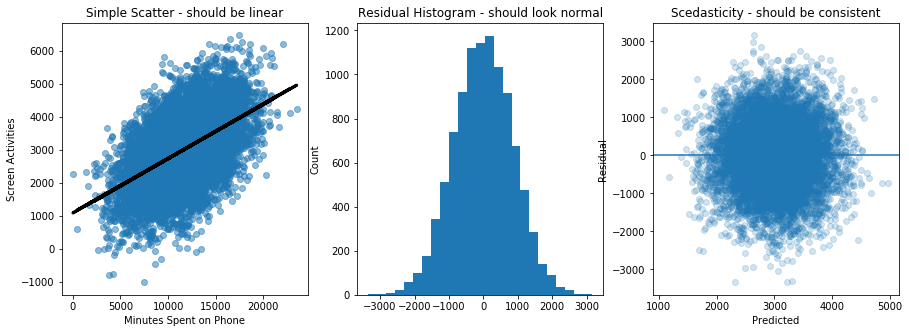

In [15]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.5)

plt.plot(x, cross_val_predict(regr,pd.DataFrame(x),y, cv=10), color='black', linewidth=3)
plt.title('Simple Scatter - should be linear')
plt.xlabel('Minutes Spent on Phone')
plt.ylabel('Screen Activities')
plt.subplot(132)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()
#annotate charts? sample#, output std, modeled std

# What if the target variable had a right skew instead of being normally distributed?

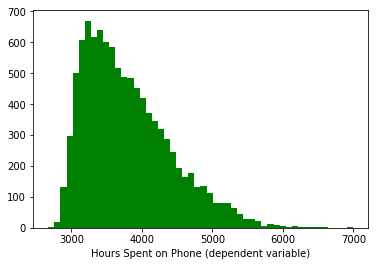

In [16]:
rightskew = createSet(targetskew=10, size=10000)
plt.hist(rightskew.df.minSpent, color='g', bins=50)
plt.xlabel('Hours Spent on Phone (dependent variable)')
plt.show()

regr = linear_model.LinearRegression()

In [17]:
#sklearn
x = rightskew.df['screenActions']
y = rightskew.df['minSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)
#statsmodels

linear_formula = 'minSpent ~ screenActions'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=rightskew.df).fit()
lm.summary()

Fold Scores:  [0.25186172 0.20867097 0.2117278  0.23423554 0.27492471 0.21797817
 0.17450352 0.27100146 0.24907726 0.25515218]

Average Score:  0.23491333330609834

Coefficients: [0.10042671]

Intercept: 
 2710.5267904899774

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               minSpent   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     3094.
Date:                Sat, 29 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:09:16   Log-Likelihood:                -77050.
No. Observations:               10000   AIC:                         1.541e+05
Df Residuals:                    9998   BIC:                         1.541e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2710.5268     20.294    133.565      0.000    2670.747    2750.307
screenActions     0.1004      0.002     55.622      0.000       0.097       0.104
==============================================================================
Omnibus:                      844.906   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1087.938
Skew:                           0.750   Prob(JB):                    5.72e-237
Kurtosis:                       3.601   Cond. No.                     4.25e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

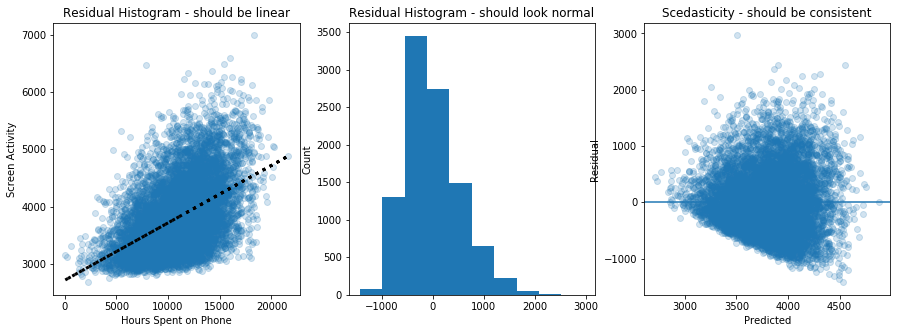

In [18]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.2)
plt.plot(x, regr.predict(pd.DataFrame(x)), color='black', lw=3, ls='dotted')
plt.title('Residual Histogram - should be linear')
plt.xlabel('Hours Spent on Phone')
plt.ylabel('Screen Activity')
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

In [19]:
# If we use a transformation to reduce the skew, how much does it help?

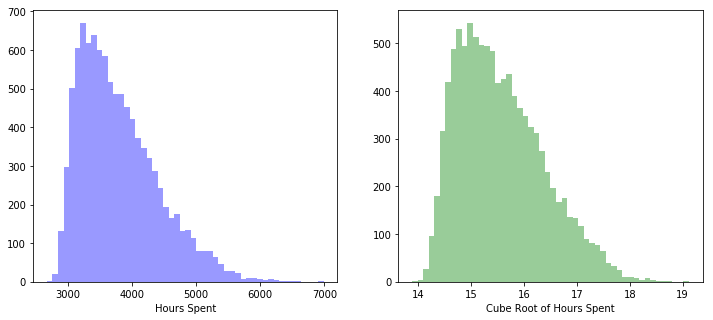

In [20]:
plt.figure(figsize=[12,5])
plt.subplot(121)
plt.hist(rightskew.df.minSpent, color='b', bins=50, alpha=.4)
plt.xlabel('Hours Spent')
plt.subplot(122)
plt.hist(rightskew.df.minSpent**(1/3), color='g', bins=50, alpha=.4)
plt.xlabel('Cube Root of Hours Spent')
plt.show()

In [21]:
rightskew.df['cube_rt_minSpent'] = rightskew.df['minSpent']**(1/3)
y = rightskew.df['cube_rt_minSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)
#statsmodels

linear_formula = 'cube_rt_minSpent ~ screenActions'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=rightskew.df).fit()
lm.summary()

Fold Scores:  [0.25733244 0.21684831 0.21496992 0.23679913 0.27999564 0.22388208
 0.17861347 0.27718479 0.25680438 0.26076969]

Average Score:  0.2403199837858835

Coefficients: [0.00013451]

Intercept: 
 14.10267624870719

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       cube_rt_minSpent   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     3184.
Date:                Sat, 29 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:09:17   Log-Likelihood:                -10751.
No. Observations:               10000   AIC:                         2.151e+04
Df Residuals:                    9998   BIC:                         2.152e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        14.1027      0.027    526.338      0.000      14.050      14.155
screenActions     0.0001   2.38e-06     56.426      0.000       0.000       0.000
==============================================================================
Omnibus:                      424.981   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              480.710
Skew:                           0.536   Prob(JB):                    4.12e-105
Kurtosis:                       3.053   Cond. No.                     4.25e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

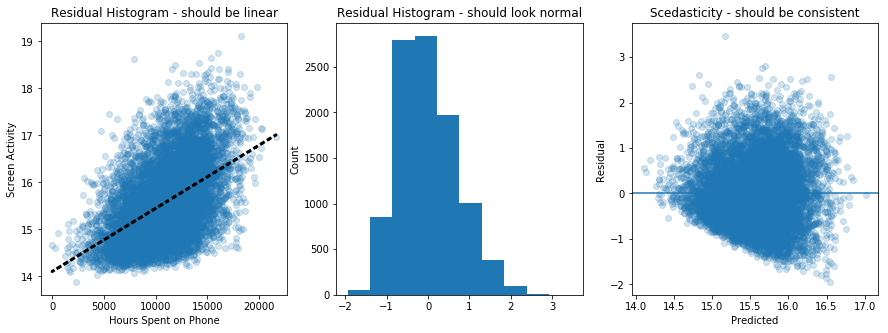

In [22]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.2)
plt.plot(x, regr.predict(pd.DataFrame(x)), color='black', lw=3, ls='dotted')
plt.title('Residual Histogram - should be linear')
plt.xlabel('Hours Spent on Phone')
plt.ylabel('Screen Activity')
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

# How do other types of regressors do?

In [23]:
print("NORMAL:\n")
x = normal.df['screenActions']
y = normal.df['minSpent']
knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score and std with 30 neighbors: ",np.mean(scores), np.std(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores), np.std(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores), np.std(scores))
print('\n','-'*40)


#TOO SLOW:
# svm = SVR(kernel='linear')
# svm.fit(pd.DataFrame(x),y)
# scores = cross_val_score(svm,pd.DataFrame(x),y,cv=5)
# print("SVM Regressor: ",scores)
# print("\nAverage Score: ",np.mean(scores))
# print('\n','-'*40)

#add std of the folds

NORMAL:

KNN:  [0.24465151 0.21048209 0.22126464 0.25157929 0.20773932 0.26104017
 0.21606017 0.18515243 0.27778014 0.23430759]

Average Score and std with 30 neighbors:  0.23100573447148315 0.026633855341799215

 ----------------------------------------
Random Forest Regressor:  [0.2608153  0.24112784 0.24570237 0.26761484 0.22830555 0.2713083
 0.25145264 0.20754137 0.28439458 0.25526271]

Average Score:  0.25135255057200706 0.02108640751533097

 ----------------------------------------
Gradient-Boosted Regressor:  [0.26069083 0.2409015  0.24454074 0.27072025 0.23028567 0.26945359
 0.24911696 0.20690573 0.28728268 0.25442003]

Average Score:  0.2514317980739308 0.021610729797540865

 ----------------------------------------


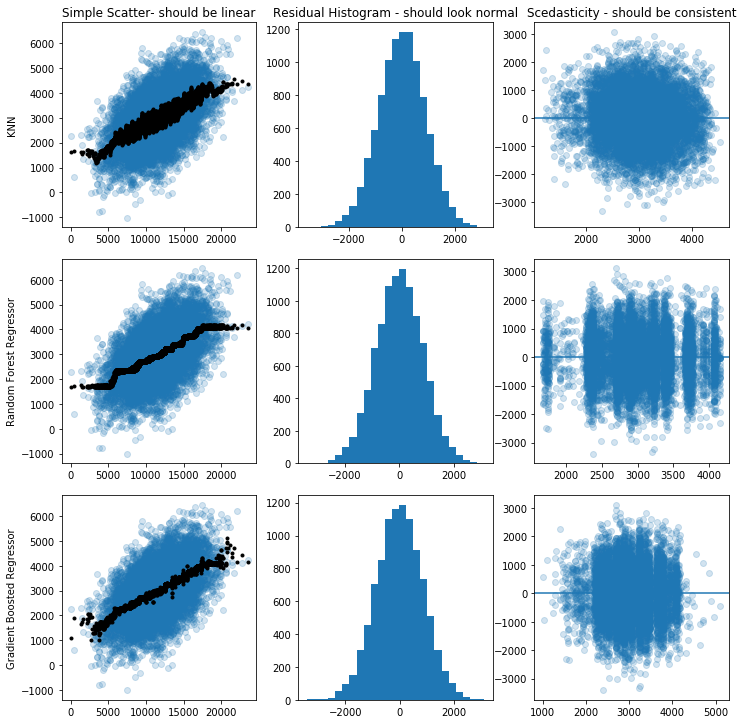

In [24]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

In [25]:
# Skewed Target Variable:

print("SKEWED TARGET VARIABLE:\n")
x = rightskew.df['screenActions']
y = rightskew.df['minSpent']
knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

SKEWED TARGET VARIABLE:

KNN:  [0.22913886 0.18747788 0.19760366 0.23216014 0.25932283 0.185868
 0.15048936 0.26720056 0.24932696 0.24637034]

Average Score with 30 neighbors:  0.22049585829959656

 ----------------------------------------
Random Forest Regressor:  [0.25225017 0.20505524 0.21633229 0.23837768 0.28103993 0.21579625
 0.16788643 0.27687529 0.25711549 0.25841793]

Average Score:  0.23691466896721605

 ----------------------------------------
Gradient-Boosted Regressor:  [0.2463739  0.20222854 0.21513045 0.23798802 0.27836833 0.21455483
 0.17006083 0.27862403 0.26207233 0.25348322]

Average Score:  0.2358884478095899

 ----------------------------------------


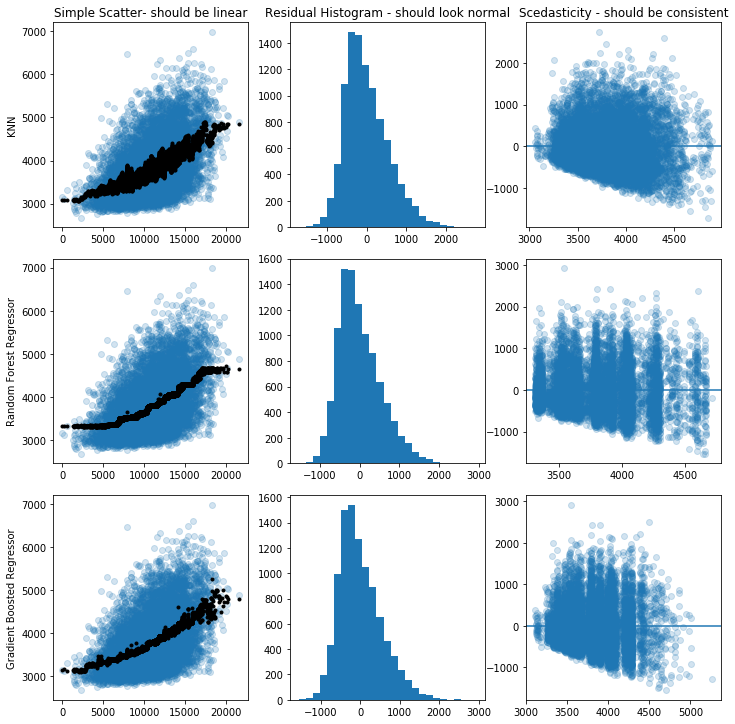

In [26]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

In [27]:
# Skewed Target Variable, adjusted:

print("Adjusted :\n")
x = rightskew.df['screenActions']
y = rightskew.df['cube_rt_minSpent']
knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

Adjusted :

KNN:  [0.2347857  0.1972392  0.19909111 0.23313994 0.26364519 0.18907046
 0.1539612  0.27046705 0.25513123 0.25130933]

Average Score with 30 neighbors:  0.22478404071675975

 ----------------------------------------
Random Forest Regressor:  [0.25124227 0.21053497 0.21604212 0.23827517 0.28239535 0.22022125
 0.17263199 0.27693838 0.26580526 0.26300874]

Average Score:  0.23970954890996152

 ----------------------------------------
Gradient-Boosted Regressor:  [0.25261407 0.21136195 0.21669804 0.23858678 0.282716   0.21915063
 0.17424608 0.28274845 0.26702926 0.2614857 ]

Average Score:  0.24066369629590603

 ----------------------------------------


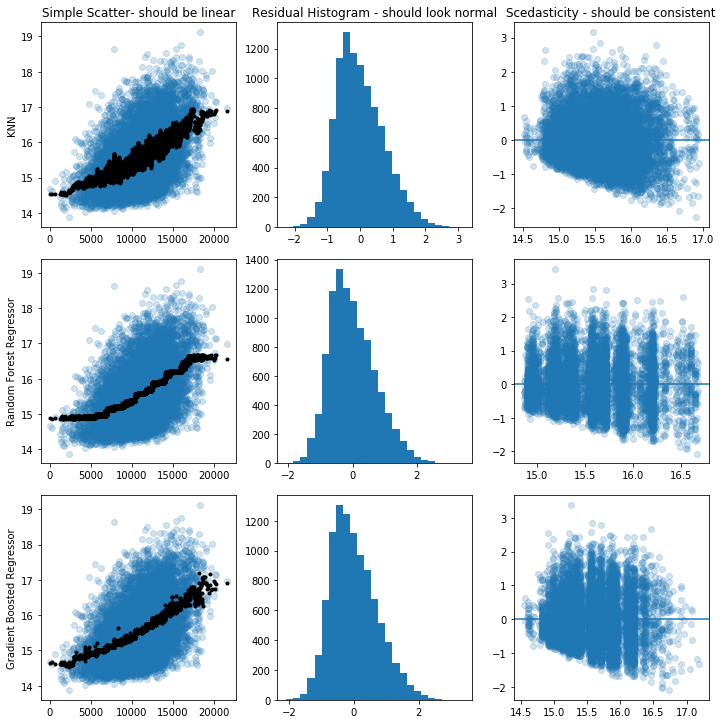

In [28]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

# Summary of 1-variable linear regression:
- 30% accurate when both dependent and independent variables are normally distributed
- If the Target Variable has a right skew, we lose 3% of accuracy, and additionally our model loses validity; our residuals tend to be large positives, and are much larger when the input variable is bigger.
- Cube-rooting the target variable to reduce the skew doesn't improve the R-squared score, but it does somewhat normalize residuals and scedasticity, which is useful.

KNN, Random Forest, and Gradient boosted regressors don't necessarily improve on the accuracy of simple linear regression, but they do seem to reduce the effects of a skewed target variable - in particular, Random Forest seems to extrapolate to the tail data better than any other model.


---------
# Attempting Linear Variable Regression with other data types

# 1: Normal Dependent variable,  1 skewed feature

In [29]:
normal = createSet(targetskew=0, size=10000)
normal.df.head(2)

,minSpent,screenActions,picsTaken,ownerAge,timesDropped,rooted,os
0,715.608863,9538.128526,51,22.241159,1,0,iOS
1,4539.781208,12910.109956,59,37.186219,2,0,Android


In [30]:
#sklearn
x = normal.df['picsTaken']
y = normal.df['minSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)

#statsmodels

linear_formula = 'minSpent ~ picsTaken'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=normal.df).fit()
lm.summary()

Fold Scores:  [0.23289212 0.22522219 0.22618779 0.25075499 0.24133121 0.22798718
 0.19099016 0.21816551 0.23333446 0.25604632]

Average Score:  0.23029119284712748

Coefficients: [54.34432186]

Intercept: 
 400.35235462906076

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               minSpent   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     3028.
Date:                Sat, 29 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:09:36   Log-Likelihood:                -82071.
No. Observations:               10000   AIC:                         1.641e+05
Df Residuals:                    9998   BIC:                         1.642e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    400.3524     47.933      8.352      0.000     306.394     494.311
picsTaken     54.3443      0.988     55.025      0.000      52.408      56.280
==============================================================================
Omnibus:                        0.058   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.972   Jarque-Bera (JB):                0.049
Skew:                          -0.005   Prob(JB):                        0.976
Kurtosis:                       3.005   Cond. No.                         262.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

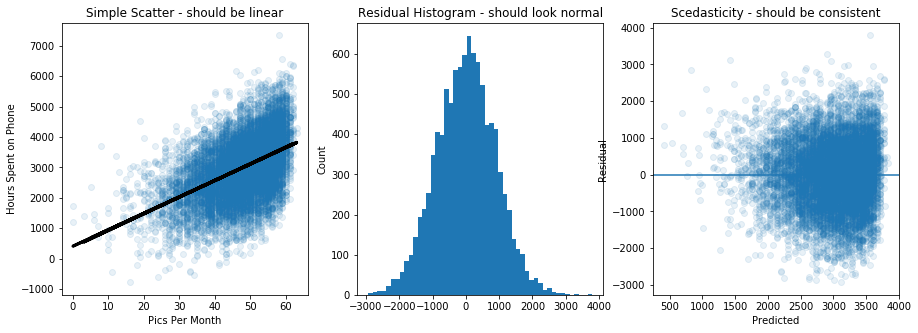

In [31]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.1)
plt.plot(x, pred, color='black', linewidth=3)
plt.title('Simple Scatter - should be linear')
plt.ylabel('Hours Spent on Phone')
plt.xlabel('Pics Per Month')
plt.subplot(132)
plt.hist(residual, bins=50)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.1)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

# Let's see how other models do

In [32]:
print("NORMAL:\n")
x = normal.df['picsTaken']
y = normal.df['minSpent']
knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=4)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)


#TOO SLOW:
# svm = SVR(kernel='linear')
# svm.fit(pd.DataFrame(x),y)
# scores = cross_val_score(svm,pd.DataFrame(x),y,cv=5)
# print("SVM Regressor: ",scores)
# print("\nAverage Score: ",np.mean(scores))
# print('\n','-'*40)


NORMAL:

KNN:  [0.23093173 0.23021696 0.2110551  0.22284455 0.22369434 0.22090663
 0.17504305 0.21416149 0.23228565 0.24615084]

Average Score with 30 neighbors:  0.22072903411214928

 ----------------------------------------
Random Forest Regressor:  [0.24180257 0.2481558  0.23774006 0.26100528 0.25398432 0.23174401
 0.19988435 0.22612233 0.24944297 0.2723415 ]

Average Score:  0.24222231971074065

 ----------------------------------------
Gradient-Boosted Regressor:  [0.24060203 0.24776473 0.23667316 0.26306553 0.2540492  0.23370194
 0.19937953 0.22649608 0.24654717 0.27049577]

Average Score:  0.24187751417658174

 ----------------------------------------


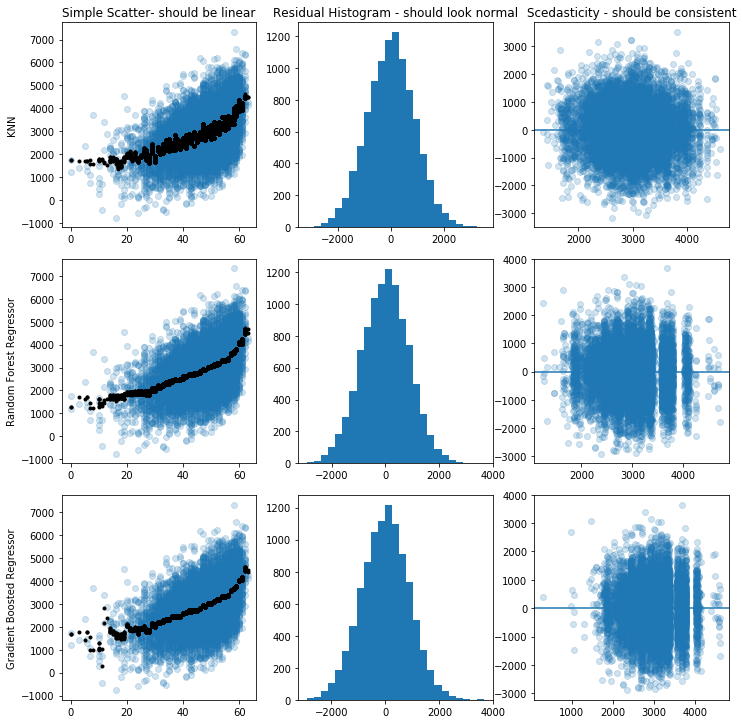

In [33]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

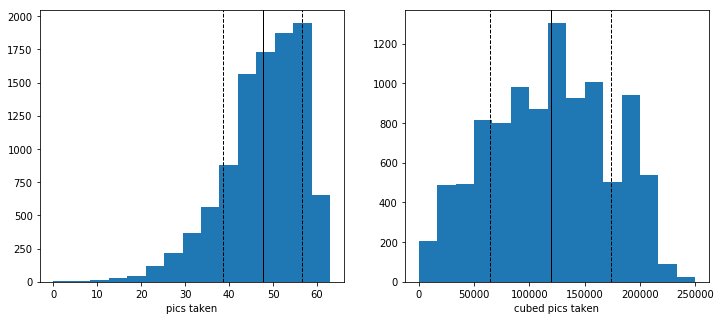

In [34]:
#Can a transformation help improve our ability to use linear regression?
fig = plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.hist(normal.df.picsTaken, bins=15)
plt.xlabel('pics taken')
plt.axvline(normal.df['picsTaken'].mean(), color='k', linestyle='solid', linewidth=1)
plt.axvline(normal.df['picsTaken'].mean() - normal.df['picsTaken'].std(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(normal.df['picsTaken'].mean() + normal.df['picsTaken'].std(), color='k', linestyle='dashed', linewidth=1)
plt.subplot(1,2,2)
cubed = normal.df.picsTaken**3
plt.axvline(cubed.mean(), color='k', linestyle='solid', linewidth=1)
plt.axvline(cubed.mean() - cubed.std(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(cubed.mean() + cubed.std(), color='k', linestyle='dashed', linewidth=1)
plt.hist(cubed, bins=15)
plt.xlabel('cubed pics taken')
plt.show()

In [35]:
#sklearn
x = cubed
y = normal.df['minSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)

#statsmodels

linear_formula = 'minSpent ~ cubed'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=normal.df).fit()
lm.summary()

Fold Scores:  [0.23412703 0.24629529 0.23242663 0.26555698 0.24962458 0.22773535
 0.19507654 0.22359133 0.24463108 0.26598543]

Average Score:  0.23850502279172553

Coefficients: [0.00906546]

Intercept: 
 1910.3709652455111

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               minSpent   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     3167.
Date:                Sat, 29 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:09:42   Log-Likelihood:                -82017.
No. Observations:               10000   AIC:                         1.640e+05
Df Residuals:                    9998   BIC:                         1.641e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1910.3710     21.153     90.310      0.000    1868.906    1951.836
cubed          0.0091      0.000     56.278      0.000       0.009       0.009
==============================================================================
Omnibus:                        0.116   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.944   Jarque-Bera (JB):                0.115
Skew:                          -0.008   Prob(JB):                        0.944
Kurtosis:                       3.000   Cond. No.                     3.15e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

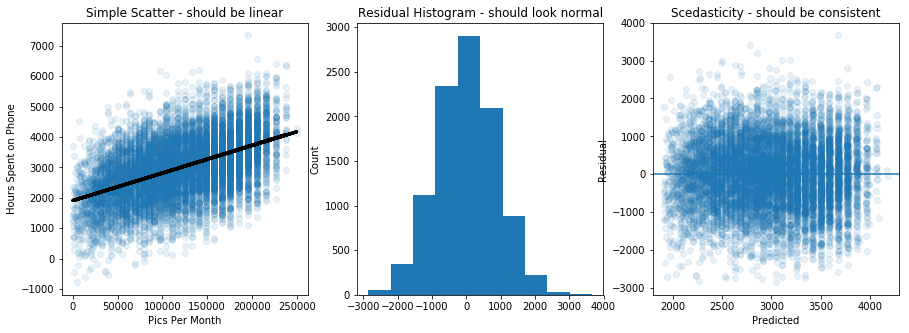

In [36]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.1)
plt.plot(x, pred, color='black', linewidth=3)
plt.title('Simple Scatter - should be linear')
plt.ylabel('Hours Spent on Phone')
plt.xlabel('Pics Per Month')
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.1)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

In [37]:
print("NORMAL:\n")

knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=4)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)


#TOO SLOW:
# svm = SVR(kernel='linear')
# svm.fit(pd.DataFrame(x),y)
# scores = cross_val_score(svm,pd.DataFrame(x),y,cv=5)
# print("SVM Regressor: ",scores)
# print("\nAverage Score: ",np.mean(scores))
# print('\n','-'*40)


NORMAL:

KNN:  [0.23052575 0.23056734 0.21145015 0.22289425 0.22378021 0.22132749
 0.17462384 0.21378957 0.23322833 0.24658577]

Average Score with 30 neighbors:  0.2208772706370467

 ----------------------------------------
Random Forest Regressor:  [0.23977684 0.24833293 0.23666221 0.2608031  0.25353579 0.23278251
 0.19871376 0.22600174 0.24671347 0.26978752]

Average Score:  0.24131098658197186

 ----------------------------------------
Gradient-Boosted Regressor:  [0.24060203 0.24776473 0.23667316 0.26306553 0.2540492  0.23370194
 0.1994924  0.22649608 0.24654717 0.27049577]

Average Score:  0.2418888007378041

 ----------------------------------------


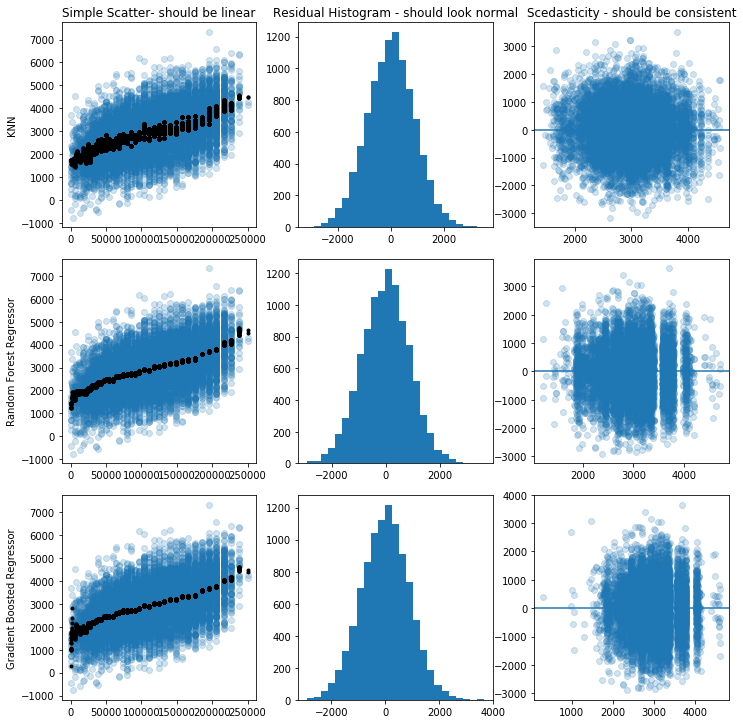

In [38]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

# Normal Dependent Variable, Poisson feature

In [39]:
normal = createSet(targetskew=0, size=10000)
#sklearn
x = normal.df['timesDropped']
y = normal.df['minSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)

#statsmodels

linear_formula = 'minSpent ~ timesDropped'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=normal.df).fit()
lm.summary()

Fold Scores:  [0.18050023 0.19121433 0.21028929 0.17703639 0.17596877 0.21621474
 0.22170824 0.17669712 0.2076847  0.21059852]

Average Score:  0.1967912337644009

Coefficients: [332.56115757]

Intercept: 
 2582.052874851495

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               minSpent   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     2470.
Date:                Sat, 29 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:09:48   Log-Likelihood:                -82189.
No. Observations:               10000   AIC:                         1.644e+05
Df Residuals:                    9998   BIC:                         1.644e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2582.0529     12.244    210.875      0.000    2558.051    2606.055
timesDropped   332.5612      6.691     49.704      0.000     319.446     345.677
==============================================================================
Omnibus:                       88.962   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.872
Skew:                           0.088   Prob(JB):                     2.31e-29
Kurtosis:                       3.535   Cond. No.                         2.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

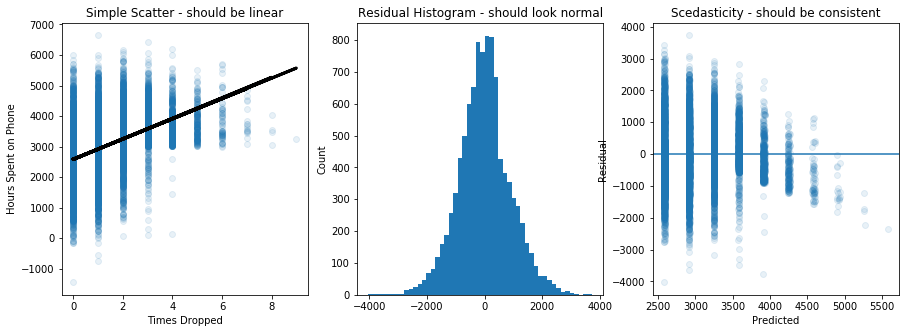

In [40]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.1)
plt.plot(x, pred, color='black', linewidth=3)
plt.title('Simple Scatter - should be linear')
plt.ylabel('Hours Spent on Phone')
plt.xlabel('Times Dropped')
plt.subplot(132)
plt.hist(residual, bins=50)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.1)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

# Let's see how other models do

In [41]:
print("NORMAL:\n")

knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=4)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)


#TOO SLOW:
# svm = SVR(kernel='linear')
# svm.fit(pd.DataFrame(x),y)
# scores = cross_val_score(svm,pd.DataFrame(x),y,cv=5)
# print("SVM Regressor: ",scores)
# print("\nAverage Score: ",np.mean(scores))
# print('\n','-'*40)


NORMAL:

KNN:  [0.19481707 0.18196617 0.18803297 0.14532371 0.17982766 0.20279539
 0.22375312 0.18171048 0.21131635 0.21723443]

Average Score with 30 neighbors:  0.19267773558954734

 ----------------------------------------
Random Forest Regressor:  [0.20745811 0.19741954 0.23297149 0.19991331 0.20238255 0.2297528
 0.24947879 0.20828041 0.23568386 0.22942032]

Average Score:  0.21927611775690412

 ----------------------------------------
Gradient-Boosted Regressor:  [0.20747826 0.19767773 0.23282467 0.20016059 0.20277195 0.22902067
 0.24925006 0.20770801 0.2355336  0.22921463]

Average Score:  0.21916401645938755

 ----------------------------------------


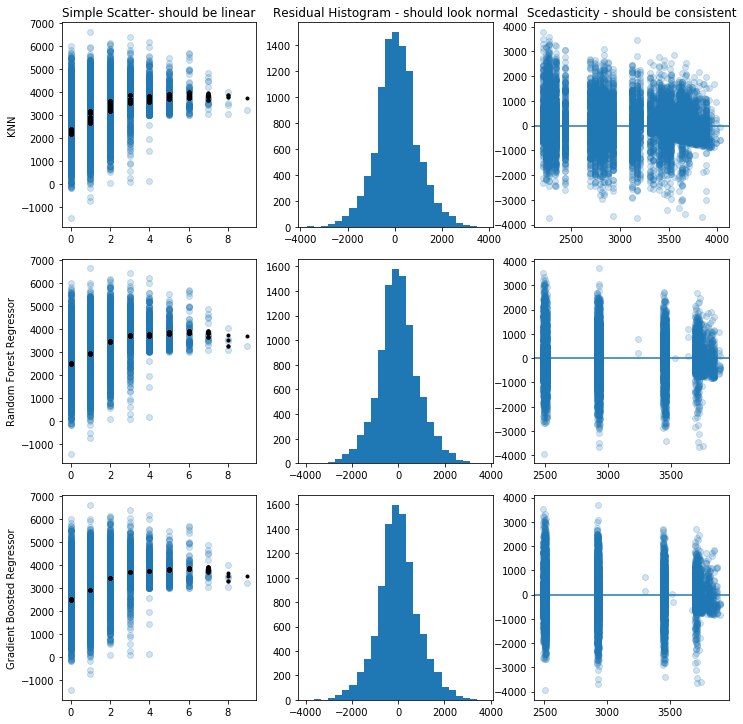

In [42]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

# Bernoulli feature / categorical

In [58]:
bern = createSet()
bools.df = pd.get_dummies(bern.df, columns=['os'])
bools.df.head()

,minSpent,screenActions,picsTaken,ownerAge,timesDropped,rooted,os_Android,os_iOS,os_other
0,4817.896170,19204.942703,39,49.818758,3,0,1,0,0
1,4469.139800,13656.593986,57,52.901271,5,0,1,0,0
2,3884.949882,10344.640110,50,35.365305,3,0,0,1,0
3,2375.646191,10653.004186,51,34.022224,1,0,1,0,0
4,2920.543486,12688.972436,48,31.845980,1,0,0,1,0


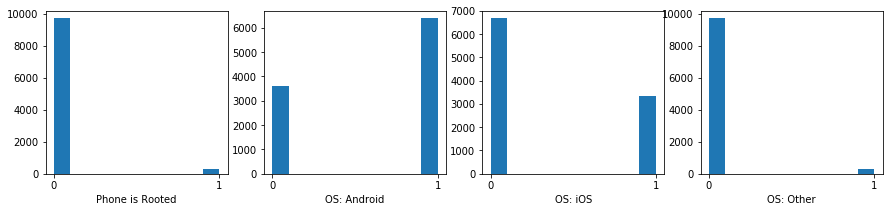

In [67]:
fig = plt.figure(figsize=[15,3])
plt.subplot(1,4,1)
plt.hist(bools.df.rooted)
plt.xlabel('Phone is Rooted')
plt.xticks([0,1])
plt.subplot(1,4,2)
plt.xlabel('OS: Android')
plt.hist(bools.df.os_Android)
plt.xticks([0,1])
plt.subplot(1,4,3)
plt.xlabel('OS: iOS')
plt.hist(bools.df.os_iOS)
plt.xticks([0,1])
plt.subplot(1,4,4)
plt.xticks([0,1])
plt.xlabel('OS: Other')
plt.hist(bools.df.os_other)
plt.show()

In [68]:

#sklearn
x = bools.df[['rooted', 'os_Android', 'os_iOS', 'os_other']]
y = bools.df['minSpent']
regr.fit(x,y)
scores = cross_val_score(regr,x,y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)

#statsmodels

linear_formula = 'minSpent ~ rooted+os_Android+os_iOS+os_other'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=bools.df).fit()
lm.summary()

Fold Scores:  [0.01550145 0.00756764 0.0182251  0.01027208 0.01449565 0.01150078
 0.01161699 0.00588258 0.01122299 0.00364068]

Average Score:  0.01099259579917936

Coefficients: [ 6.26960459e+02 -2.36701092e+14 -2.36701092e+14 -2.36701092e+14]

Intercept: 
 236701091804629.72

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               minSpent   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     29.39
Date:                Sat, 29 Dec 2018   Prob (F-statistic):           2.49e-24
Time:                        16:34:39   Log-Likelihood:                -83193.
No. Observations:               10000   AIC:                         1.664e+05
Df Residuals:                    9995   BIC:                         1.664e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.063e+14   1.87e+14     -2.175      0.030   -7.72e+14   -4.01e+13
rooted       634.9642     59.489     10.674      0.000     518.353     751.576
os_Android  4.063e+14   1.87e+14      2.175      0.030    4.01e+13    7.72e+14
os_iOS      4.063e+14   1.87e+14      2.175      0.030    4.01e+13    7.72e+14
os_other    4.063e+14   1.87e+14      2.175      0.030    4.01e+13    7.72e+14
==============================================================================
Omnibus:                        3.499   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.174   Jarque-Bera (JB):                3.471
Skew:                           0.045   Prob(JB):                        0.176
Kurtosis:                       3.019   Cond. No.                     4.67e+13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.06e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

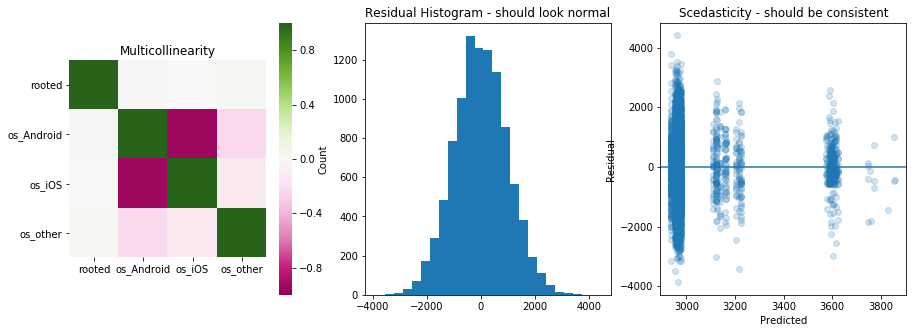

In [69]:
pred = cross_val_predict(regr,x,y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.title('Multicollinearity')
sns.heatmap(x.corr(), vmin = -1,square=True, cmap="PiYG")
plt.subplot(132)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

In [71]:
print("NORMAL:\n")

knn = neighbors.KNeighborsRegressor(n_neighbors=10)
knn.fit(x,y)
scores = cross_val_score(knn,x,y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(x,y)
scores = cross_val_score(rfr,x,y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(x,y)
scores = cross_val_score(gbr,x,y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))

NORMAL:

KNN:  [-0.14846724 -0.0446416  -0.05765962 -0.12463042 -0.04782884 -0.07949313
 -0.07935938 -0.10749244 -0.07598717 -0.17392757]

Average Score with 30 neighbors:  -0.09394873972702733

 ----------------------------------------
Random Forest Regressor:  [0.01578727 0.0059488  0.01616633 0.01208701 0.01646922 0.01219606
 0.00972139 0.00819205 0.01103233 0.00300251]

Average Score:  0.011060296396511248

 ----------------------------------------
Gradient-Boosted Regressor:  [0.01604648 0.00645406 0.0167616  0.01222175 0.01578486 0.01237605
 0.00938162 0.00872853 0.01090635 0.0028659 ]

Average Score:  0.011152720097081103


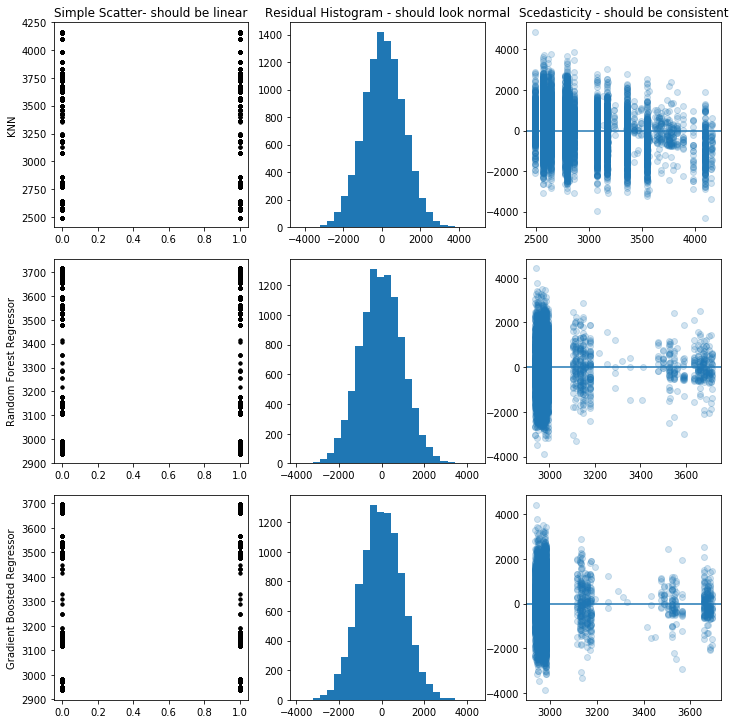

In [73]:
#Let's check how our output looks:
pred = cross_val_predict(knn,x,y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
#plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,x,y,cv=10)
residual = y - pred

plt.subplot(334)
#plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,x,y,cv=10)
residual = y - pred

plt.subplot(337)
#plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

# Bringing it all together (Normal Target)

In [77]:
full = createSet()
full.df = pd.get_dummies(full.df, columns=['os'])
full.df['picsTaken3'] = full.df['picsTaken']**3
full.df.head(1)

,minSpent,screenActions,picsTaken,ownerAge,timesDropped,rooted,os_Android,os_iOS,os_other,picsTaken3
0,4417.342018,18622.592079,51,34.604817,3,0,1,0,0,132651


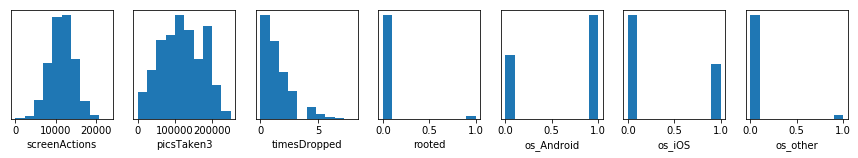

In [90]:
#sklearn
x = full.df[['screenActions', 'picsTaken3', 'timesDropped', 'rooted', 'os_Android', 'os_iOS', 'os_other']]
y = full.df['minSpent']

fig=plt.figure(figsize=[15,2])
for i,col in enumerate(x.columns):
    plt.subplot(1,7,i+1)
    plt.hist(x[col])
    plt.yticks([])
    plt.xlabel(col)
plt.show()
    

In [79]:
regr.fit(x,y)
scores = cross_val_score(regr,x,y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)

#statsmodels

linear_formula = 'minSpent ~ screenActions+picsTaken3+timesDropped+rooted+os_Android+os_iOS+os_other'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=full.df).fit()
lm.summary()

Fold Scores:  [0.56081109 0.58000252 0.54596035 0.51425859 0.56424427 0.57001085
 0.54134137 0.56239426 0.52975068 0.57448077]

Average Score:  0.5543254751602087

Coefficients: [ 1.46122364e-01  7.99466240e-03  1.88656605e+02  2.84192490e+02
 -2.53185815e+01  1.85972258e-01  2.51326092e+01]

Intercept: 
 133.31919449958014

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               minSpent   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     2083.
Date:                Sat, 29 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:52:13   Log-Likelihood:                -79158.
No. Observations:               10000   AIC:                         1.583e+05
Df Residuals:                    9993   BIC:                         1.584e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        99.9894     24.337      4.108      0.000      52.284     147.695
screenActions     0.1461      0.002     64.146      0.000       0.142       0.151
picsTaken3        0.0080      0.000     64.321      0.000       0.008       0.008
timesDropped    188.6566      5.161     36.557      0.000     178.541     198.773
rooted          284.1925     40.367      7.040      0.000     205.065     363.320
os_Android        8.0112     13.603      0.589      0.556     -18.654      34.676
os_iOS           33.5158     14.701      2.280      0.023       4.698      62.334
os_other         58.4624     28.444      2.055      0.040       2.707     114.218
==============================================================================
Omnibus:                       36.910   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.721
Skew:                           0.092   Prob(JB):                     5.29e-10
Kurtosis:                       3.263   Cond. No.                     5.74e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.28e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

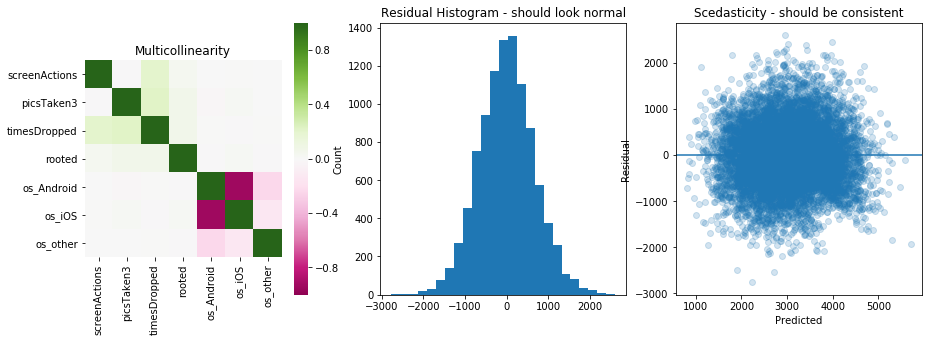

In [91]:
pred = cross_val_predict(regr,x,y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.title('Multicollinearity')
sns.heatmap(x.corr(), vmin = -1,square=True, cmap="PiYG")
plt.subplot(132)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

In [92]:
print("NORMAL:\n")

knn = neighbors.KNeighborsRegressor(n_neighbors=10)
knn.fit(x,y)
scores = cross_val_score(knn,x,y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=100, max_depth=3)
rfr.fit(x,y)
scores = cross_val_score(rfr,x,y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(x,y)
scores = cross_val_score(gbr,x,y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))

NORMAL:

KNN:  [0.45124815 0.47334986 0.37162718 0.39114662 0.4816083  0.45015254
 0.42860784 0.47179266 0.41141396 0.45508689]

Average Score with 30 neighbors:  0.43860339969605855

 ----------------------------------------
Random Forest Regressor:  [0.43198794 0.47335468 0.43282915 0.41717221 0.4348764  0.46300604
 0.44595438 0.46364931 0.41624775 0.457826  ]

Average Score:  0.4436903857476467

 ----------------------------------------
Gradient-Boosted Regressor:  [0.56909498 0.60006453 0.55154783 0.51996719 0.57355643 0.58067571
 0.55508505 0.57390483 0.54271753 0.58073886]

Average Score:  0.5647352940364818


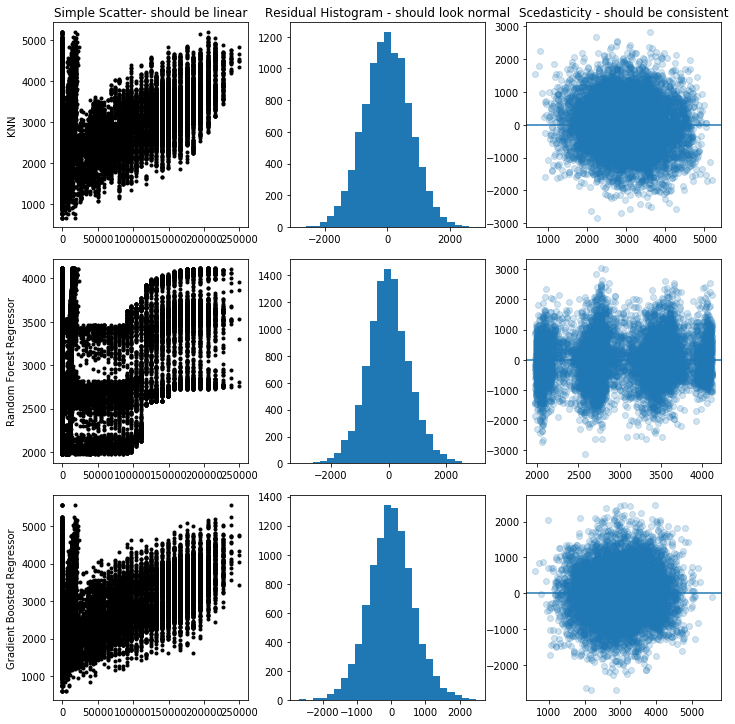

In [93]:
#Let's check how our output looks:
pred = cross_val_predict(knn,x,y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
#plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,x,y,cv=10)
residual = y - pred

plt.subplot(334)
#plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,x,y,cv=10)
residual = y - pred

plt.subplot(337)
#plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

# Next Ideas?

- smaller samples?
- Central Limit Theorem?
- error measurement?
- switch to logistic regression? Confusion matrix, ROC
- added outliers?

In [48]:
# Central Limit Theorem:
#large data set with no normal distribution
#sample over and over, the means will be normally distributed

# Central Limit Theorem demonstration

In [49]:
clt = createSet(size=100000, targetskew=-10)

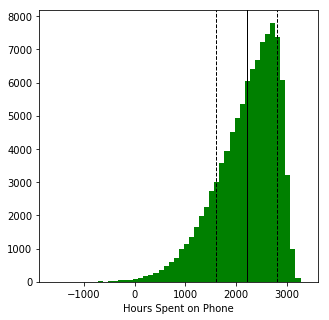

In [95]:
plt.figure(figsize=[5,5])
#plt.subplot(121)
plt.hist(clt.df.minSpent, bins=50, color='g')
plt.axvline(clt.df.minSpent.mean(), color='k', linestyle='solid', linewidth=1)
plt.axvline(clt.df.minSpent.mean() - clt.df.minSpent.std(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(clt.df.minSpent.mean() + clt.df.minSpent.std(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Hours Spent on Phone')
#plt.subplot(122)
#plt.hist(clt.df.picsTaken, bins=50)
#plt.xlabel('Pics Taken')
plt.show()

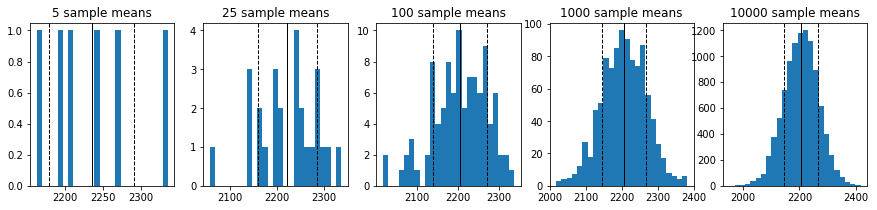

In [110]:
sampleMeans = []
prints = [5,25,100,1000,10000]
plt.figure(figsize=[15,3])
j = 1
for i in range (10001):
    samples = clt.df.sample(100, replace=True,axis=0)
    sMean = np.mean(samples.minSpent)
    sampleMeans.append(sMean)
    if i in prints:
        plt.subplot(1,5,j)
        plt.hist(sampleMeans, bins=25)
        plt.title(str(i)+" sample means")
        plt.axvline(np.mean(sampleMeans), color='k', linestyle='solid', linewidth=1)
        plt.axvline(np.mean(sampleMeans) - np.std(sampleMeans), color='k', linestyle='dashed', linewidth=1)
        plt.axvline(np.mean(sampleMeans) + np.std(sampleMeans), color='k', linestyle='dashed', linewidth=1)
        j = j+1
plt.show()
    

# Law of Large Numbers

In [52]:
loln = createSet(targetskew=0)

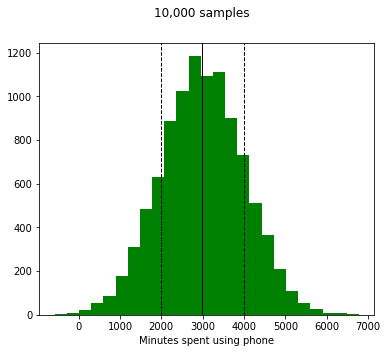

In [53]:

fig = plt.figure(figsize=[6,5])
fig.patch.set_facecolor('white')
fig.suptitle("10,000 samples")
plt.hist(loln.df.minSpent, color='g',bins=25)
plt.axvline(loln.df.minSpent.mean(), color='k', linestyle='solid', linewidth=1)
plt.axvline(loln.df.minSpent.mean() - loln.df.minSpent.std(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(loln.df.minSpent.mean() + loln.df.minSpent.std(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Minutes spent using phone')
plt.show()

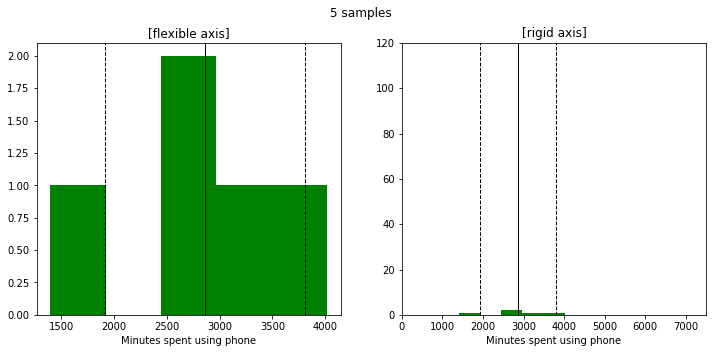

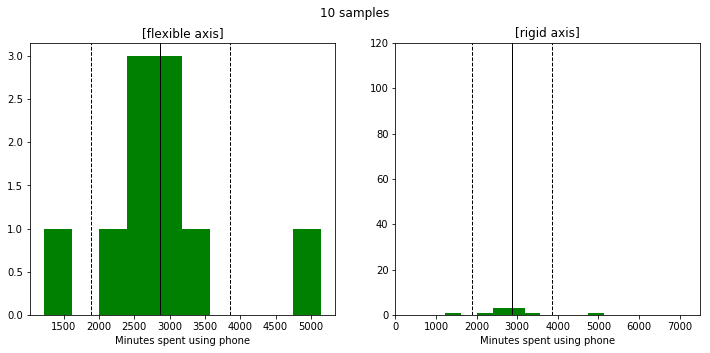

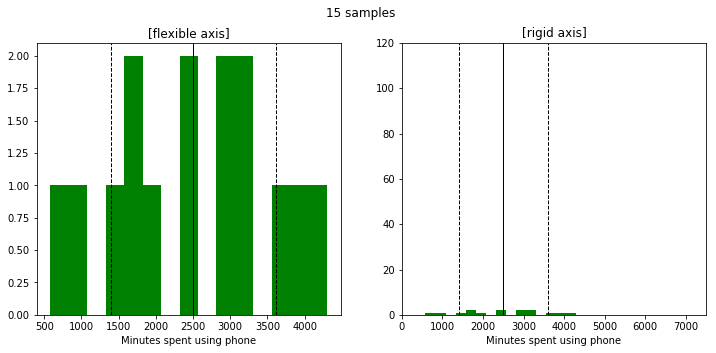

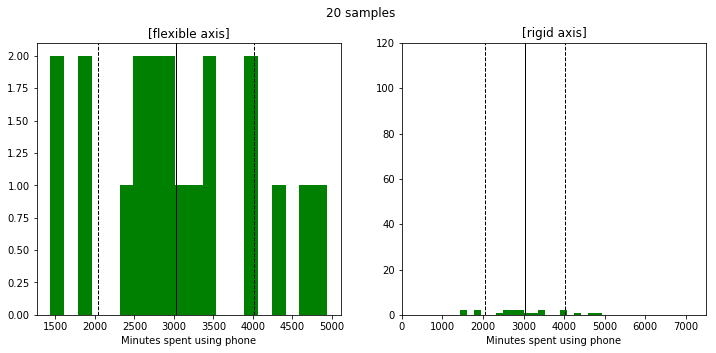

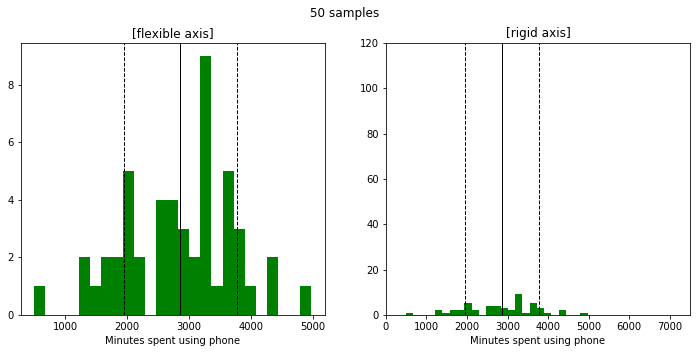

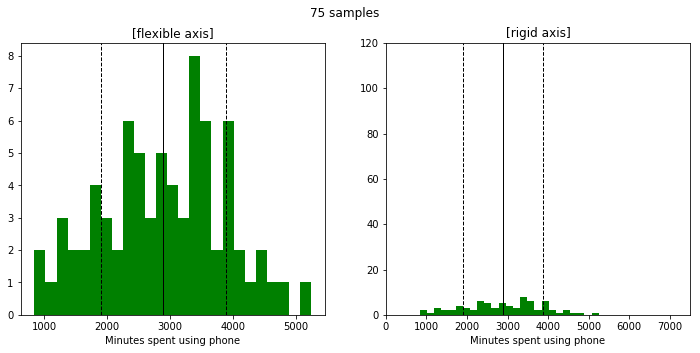

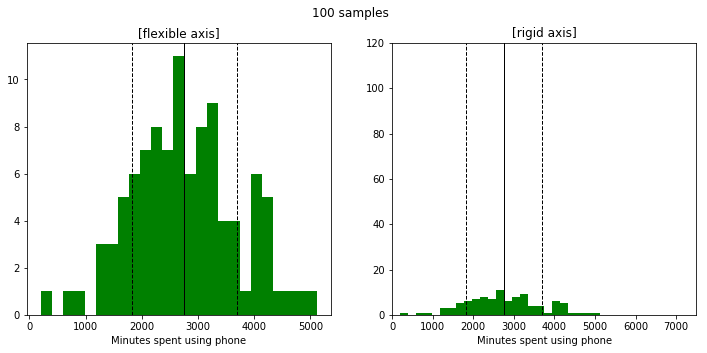

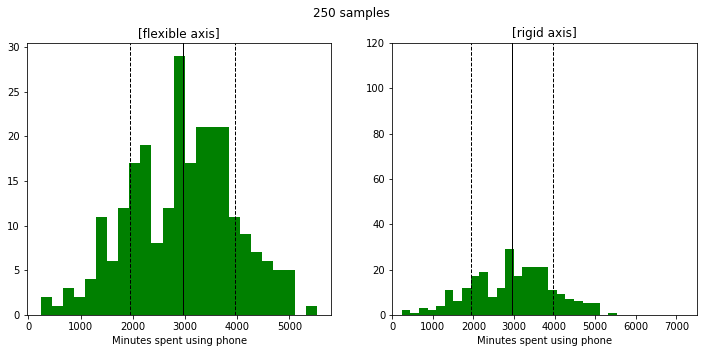

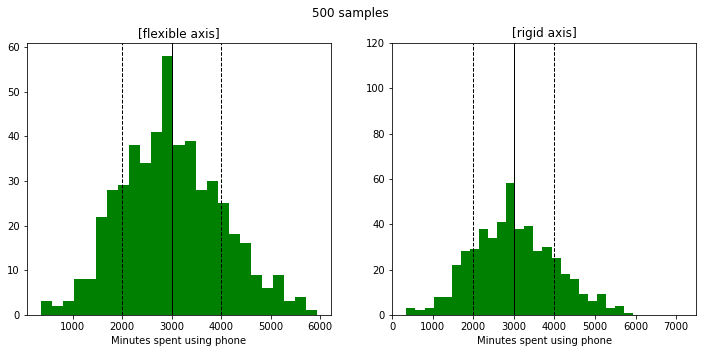

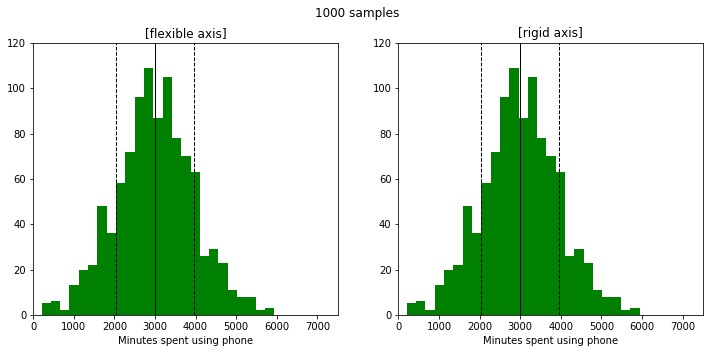

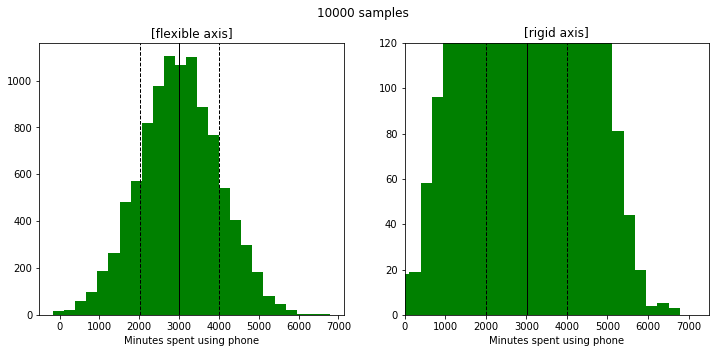

In [54]:
sizes = [5,10,15,20,50, 75, 100,250,500,1000, 10000]
for i in sizes:
    samples = loln.df.sample(i,replace=True, axis=0)
    fig = plt.figure(figsize=[12,5])
    fig.patch.set_facecolor('white')
    fig.suptitle(str(i) + " samples")
    plt.subplot(121)
    plt.xlabel('Minutes spent using phone')
    plt.title('[flexible axis]')
    plt.hist(samples.minSpent, color='green', bins=min(i,25))
    plt.axvline(samples.minSpent.mean(), color='k', linestyle='solid', linewidth=1)
    plt.axvline(samples.minSpent.mean() - samples.minSpent.std(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(samples.minSpent.mean() + samples.minSpent.std(), color='k', linestyle='dashed', linewidth=1)
    if i == 1000:
        plt.ylim(0,120)
        plt.xlim(0,7500)
    plt.subplot(122)
    plt.title('[rigid axis]')
    plt.xlabel('Minutes spent using phone')
    plt.axvline(samples.minSpent.mean(), color='k', linestyle='solid', linewidth=1)
    plt.axvline(samples.minSpent.mean() - samples.minSpent.std(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(samples.minSpent.mean() + samples.minSpent.std(), color='k', linestyle='dashed', linewidth=1)
    plt.ylim(0,120)
    plt.xlim(0,7500)
    plt.hist(samples.minSpent, color='green', bins=min(i,25))
    plt.show()

work  in bayesian vs frequentist thinking
p values, priors etc.

logistic regression (over/under x hours?) to discuss ROC